### 1. Import thư viện và nạp dữ liệu

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
# Nạp dữ liệu
df = pd.read_csv("diabetes_prediction_dataset.csv")

# Xem thông tin
print(df.shape)
df.head()


(100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### Tiền xử lý dữ liệu
#### Điền giá trị thiếu bằng median/mode.

#### Encode các biến phân loại (ví dụ: gender, smoking_history).

#### Chuẩn hóa dữ liệu (rất quan trọng với SVM).

In [5]:
# Điền missing
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode biến phân loại
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Chia X, y
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### 3. Chia train/test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

### 4. Huấn luyện mô hình SVM cơ bản

In [7]:
clf = svm.SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

print("Train acc:", clf.score(X_train, y_train))
print("Test acc:", clf.score(X_test, y_test))

Train acc: 0.9612125
Test acc: 0.9595


### 5. Thử nhiều kernel để chọn mô hình tốt nhất

In [8]:
kernels = ['linear','poly','rbf','sigmoid']
best_acc = -1
best_kernel = None
best_model = None

for k in kernels:
    model = svm.SVC(kernel=k, probability=True, random_state=42)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"Kernel={k}, Test acc={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_kernel = k
        best_model = model

print("Best kernel:", best_kernel, "with acc:", best_acc)

Kernel=linear, Test acc=0.9595
Kernel=poly, Test acc=0.9633
Kernel=rbf, Test acc=0.9624
Kernel=sigmoid, Test acc=0.9189
Best kernel: poly with acc: 0.96325


### 6. Tối ưu tham số bằng GridSearchCV

In [9]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear','rbf','poly'],
    'gamma': ['scale','auto']
}

grid = GridSearchCV(svm.SVC(probability=True, random_state=42),
                    param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)

Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Best CV acc: 0.9664000000000001


### 7. Đánh giá mô hình tốt nhất

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18292
           1       0.98      0.61      0.75      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.80      0.87     20000
weighted avg       0.97      0.97      0.96     20000



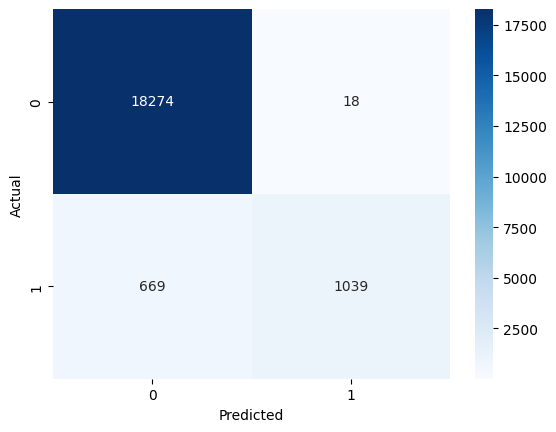

In [10]:
y_pred = grid.best_estimator_.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()